In [1]:
#!pip install keras 
#!pip install tensorflow
#!pip install tensorflow.python
#!pip install h5py

In [2]:
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np
import pandas as pd
from scipy import misc
import time
import pickle

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


### Load the prepared data.

In [4]:
def reshape_and_normalize(data):
    image_count = data.shape[0]
    temp = np.ndarray(shape=(image_count, data[0].shape[0], data[0].shape[1], 3))

    for index in range(0, image_count):
        try:
            temp[index] = data[index].reshape(data[0].shape[0], data[0].shape[1], 3)
        except ValueError:
            print(data[index].shape)
    temp = temp.astype('float32')
    temp /= 255.0

    return temp

In [5]:
print('Loading data...')

with open('full_dataset.pickle', 'rb') as handle:
    dataset = pickle.load(handle)
    
print(len(dataset['train_x']), 'train sequences')
print(len(dataset['test_x']), 'test sequences')
 
num_classes = len(dataset['labels'])
print(num_classes, 'classes.')

print('Data loaded.')

Loading data...
5120 train sequences
1704 test sequences
8 classes.
Data loaded.


### Tune an existing CNN (Multi-class)

The following code is used with modification from the sample InceptionV3 code from the Keras documentation, https://keras.io/applications/

In [6]:
loss_method='binary_crossentropy'
final_activation_function = 'sigmoid'
eval_metric = 'accuracy'
batch_size = 32

In [7]:
# Create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer 
predictions = Dense(num_classes, activation=final_activation_function)(x)

# this is the model we will train
model_tune = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_tune.compile(optimizer='rmsprop', loss=loss_method,  metrics=[eval_metric])

In [8]:
def train_evaluate_CNN(x_train, y_train, x_test, y_test, model, batch_size, epochs, verbose, show_layers,
                       validation_split, weights_filename, plot_title, augment_data = False):
    # Trains and evaluates the performance numerically and graphically of a compiled Convolutional Neural Net.
    #
    # Parameters:
    #    x_train, y_train:  The predictors and responses of the training set.
    #    x_test, y_test:  The predictors and responses of the test set.
    #    model:  The compiled CNN model.
    #    batch_size:  The batch size used in training.
    #    epochs:  The number of epochs to train.
    #    verbose:  If 1, will display the intermediate epoch training results.
    #    show_layers:  If True, will display the model layers and parameters.
    #    validation_split:  The percentage of the training set to use as a validation set for tuning.
    #    weights_filename:  The name of the file to store the tuned weights in.
    #    plot_title:  The model title to include in the performance plot.
    #
    # Returns:
    #    test_accuracy:  The test accuracy (as a float)
    #    train_time:  The time spent training the model, in seconds.
    
    if (augment_data == True):
        datagen = ImageDataGenerator(
            featurewise_center=True,
            samplewise_center=False,
            featurewise_std_normalization=True,
            samplewise_std_normalization=False,
            zca_whitening=False,
            roation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=False)
        datagen.fit(x_train)
        
    start_time = time.time()
    history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split = validation_split)
    end_time = time.time()
    train_time = end_time - start_time
    print('Time to train model with ', epochs, ' epochs is : ', train_time, ' seconds.')
    # Evaluate the performance on the testing set.
    score = model.evaluate(x_test, y_test, verbose=verbose)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    if (show_layers == 1):
        print(model.summary())
    
    model.save_weights(weights_filename + '_weights.h5')
    
    plt.plot(history.history['acc'])
    plt.axhline(y=score[1], color='r')
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Training Accuracy, " + plot_title);

    # Return the TEST set accuracy.
    return(score[1], train_time)

In [9]:
train_x = reshape_and_normalize(dataset['train_x']['poster'].as_matrix())
test_x = reshape_and_normalize(dataset['test_x']['poster'].as_matrix())
train_y = dataset['train_y']
test_y = dataset['test_y']
del dataset

Train on 4096 samples, validate on 1024 samples
Epoch 1/10
4096/4096 [==============================] - 16s - loss: 0.5043 - acc: 0.7692 - val_loss: 0.4375 - val_acc: 0.7920

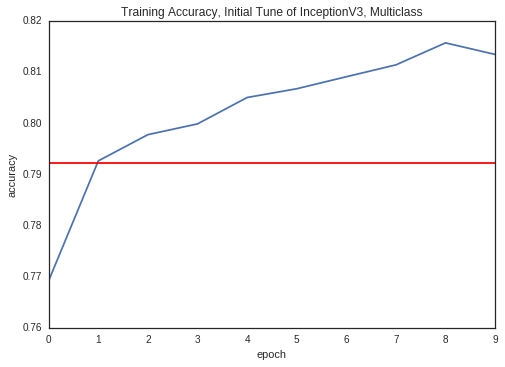

In [10]:
# train the model on the new data for a few epochs
# fine-tune the model
experiment = 'Initial Tune of InceptionV3, Multiclass'
accuracy, train_time = train_evaluate_CNN(train_x, 
                                          train_y, 
                                          test_x, 
                                          test_y, 
                                          model_tune, 
                                          batch_size=32, epochs=10, 
                                          verbose=1, show_layers=True,
                                          validation_split=0.20, 
                                          weights_filename='inceptionv3_initial', 
                                          plot_title=experiment)

In [11]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model_tune.layers[:172]:
   layer.trainable = False
for layer in model_tune.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model_tune.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=loss_method,  metrics=[eval_metric])

Train on 4096 samples, validate on 1024 samples
Epoch 1/50
4096/4096 [==============================] - 24s - loss: 0.3788 - acc: 0.8167 - val_loss: 0.4183 - val_acc: 0.7996

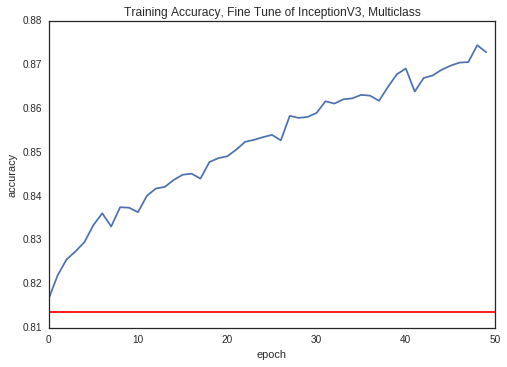

In [12]:
# Fine tune the new model, using the "fine" parameters of SGD previously defined.
experiment = 'Fine Tune of InceptionV3, Multiclass'
accuracy, train_time = train_evaluate_CNN(train_x, 
                                          train_y, 
                                          test_x, 
                                          test_y, 
                                          model_tune, 
                                          batch_size, epochs=50, 
                                          verbose=True, show_layers=False,
                                          validation_split=0.20, 
                                          weights_filename='inceptionv3_finetune', 
                                          plot_title=experiment)

In [16]:
train_probabilities = model_tune.predict(train_x)
test_probabilities = model_tune.predict(test_x)

In [19]:
# Merge the predictions back into our pickled dataset for future use.
with open('full_dataset.pickle', 'rb') as handle:
    dataset = pickle.load(handle)
    
dataset['CNN_Poster_Train_Probabilities'] = train_probabilities
dataset['CNN_Poster_Test_Probabilities'] = test_probabilities

with open('full_dataset.pickle', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

### References Used
https://keras.io/callbacks/

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://keras.io/getting-started/faq/#how-can-i-use-keras-with-datasets-that-dont-fit-in-memory

https://elitedatascience.com/keras-tutorial-deep-learning-in-python#step-4

http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/